In [1]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#!unzip "/content/drive/My Drive/Colab Notebooks/ds4440_data.zip"
!unzip "/content/drive/MyDrive/DS4440_Project/preprocessed_images.zip"

In [3]:
# Imports
import pandas as pd
import torch
import os
from PIL import Image
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])


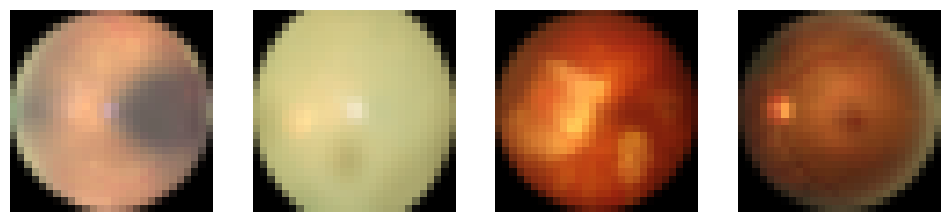

Labels: ('D', 'C', 'M', 'N')


In [32]:
# Tests that the Data is Properly Loaded by Printing
def show_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(12, 3))
    for i, image in enumerate(images):
        # Normalize image to [0, 1]
        image = image - image.min()
        image = image / image.max()
        if image.shape[0] == 1:
            axs[i].imshow(image.squeeze(), cmap='gray')
        else:
            axs[i].imshow(image.permute(1, 2, 0))
        axs[i].axis('off')
    plt.show()

images, labels = next(iter(dataloader))
show_images(images[:5])
print("Labels:", labels[:5])

## GAN

Adapted Code from [gcastro-98/synthetic-medical-images](https://github.com/gcastro-98/synthetic-medical-images)



In [ ]:
# Imports
from torch import device
from torch.cuda import is_available, device_count
from torchvision.utils import save_image
import numpy as np

In [74]:
# CONSTANTS

DEVICE = device("cuda" if is_available() else "cpu")  # (GPU if available)

nz: int = 128  # length of latent vector
ngf: int = 128  # depth of feature maps carried through the generator.
ndf: int = 64  # depth of feature maps propagated through the discriminator
nc: int = 3  # number of color channels (for color images = 3)
# niter: int = NUM_EPOCHS BATCH_SIZE  # 300
n_dnn: int = 64  # number of output features of the label's linear

# Image and Label Constants
IMAGE_SIZE: int = 64  # 128
LABEL_TO_CLASS: dict = {
    'N': 0,
    'D': 1,
    'G': 2,
    'C': 3,
    'A': 4,
    'H': 5,
    'M': 6,
    'O': 7
}
LABEL_TO_TITLE: dict = {
    'N': "Normal",
    'D': "Diabetes",
    'G': "Galucoma",
    'C': "Cataract",
    'A': "Age related Macular Degeneration",
    'H': "Hypertension",
    'M': "Pathological Myopia",
    'O': "Other diseases/abnormalities"
}
CLASS_TO_LABEL: dict = {_v: _k for _k, _v in LABEL_TO_CLASS.items()}
NUM_CLASSES: int = len(LABEL_TO_CLASS)

# ---------------------
# Training parameters
# ---------------------
BATCH_SIZE: int = 64 if IMAGE_SIZE == 64 else 32
NUM_EPOCHS: int = 200

# ---------------------
# Hyperparameters
# ---------------------
# kept same hyperparameters as https://arxiv.org/pdf/1511.06434.pdf
LEARNING_RATE: float = 0.0002
BETA_1: float = 0.5

In [92]:
# Create CustomDataset Class
class CustomDataset(Dataset):
  def __init__(self, root_dir, label_file, transform=None):
        self.root_dir = root_dir
        self.label_file = label_file
        self.transform = transform
        self.labels_df = pd.read_csv(label_file)
        self.image_files = os.listdir(root_dir)

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)

        # Extract label from the label file
        filename = self.image_files[idx]
        label = self.labels_df.loc[self.labels_df['filename'] == filename]['labels'].item()
        # Convert label to label class, to get index for encoding
        label_ind = LABEL_TO_CLASS[label]
        # one hot encoding for labels:
        label_encoded = torch.zeros(NUM_CLASSES)
        label_encoded[label_ind] = 1

        return image, label_encoded

### `synthetic-medical-images` GAN
Structure and Code from [gcastro-98/synthetic-medical-images](https://github.com/gcastro-98/synthetic-medical-images):
- `Generator64` Class
- `Discriminator64` Class
- `train_gan` method
- `

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        assert IMAGE_SIZE == 64, \
            f"This architecture is not suitable for IMAGE_SIZE = {IMAGE_SIZE}"
        super(Generator, self).__init__()

        self.y_label = nn.Sequential(
            nn.Linear(NUM_CLASSES, n_dnn),  # 120, 1000
            nn.ReLU(True)
        )

        self.yz = nn.Sequential(
            nn.Linear(nz, 2 * nz),  # 100, 200
            nn.ReLU(True)
        )

        self.main = nn.Sequential(
            nn.ConvTranspose2d(n_dnn + 2 * nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, z, y):
        # mapping noise and label
        z = self.yz(z)
        y = self.y_label(y)

        # mapping concatenated input to the main generator network
        inp = torch.cat([z, y], 1)
        inp = inp.view(-1, n_dnn + 2 * nz, 1, 1)  # 1000 + 200
        output = self.main(inp)

        return output


class Discriminator(nn.Module):
    def __init__(self):
        assert IMAGE_SIZE == 64, \
            f"This architecture is not suitable for IMAGE_SIZE = {IMAGE_SIZE}"
        super(Discriminator, self).__init__()
        # self.ngpu = _ngpu
        self.y_label = nn.Sequential(
            nn.Linear(NUM_CLASSES, 64 * 64 * 1),
            nn.ReLU(True)
        )

        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        y = self.y_label(y)
        y = y.view(-1, 1, 64, 64)
        inp = torch.cat([x, y], 1)
        output = self.main(inp)

        return output.view(-1, 1).squeeze(1)

In [91]:
def __generate_random_noise():
    return torch.randn(BATCH_SIZE, nz, device=DEVICE)


def __generate_random_labels():
    label = torch.zeros(BATCH_SIZE, NUM_CLASSES, device=DEVICE)
    for i in range(BATCH_SIZE):
        x = np.random.randint(0, NUM_CLASSES)
        label[i][x] = 1
    return label

_checkpoint_noise = __generate_random_noise()
_checkpoint_labels = __generate_random_labels()

In [90]:
def _plot_losses(g_losses, d_losses,
                 _show: bool = False) -> None:
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(g_losses, label="Generator")
    plt.plot(d_losses, label="Discriminator")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join('.img', 'losses.png'), dpi=200)
    if _show:
        plt.show()
    plt.close()

In [89]:
def train_gan(
        data_loader, use_cpu: bool = False,
        save_best_model: bool = True, save_generated_images: bool = True,
        verbose: bool = False, _freq: int = 5):
    #DEVICE = device('cpu') if use_cpu else _DEVICE
    # initialize (with weights) generator and discriminator
    net_g = Generator().to(DEVICE)
    #net_g.apply(weights_init)
    net_d = Discriminator().to(DEVICE)
    #net_d.apply(weights_init)

    # loss function and optimizers
    criterion = nn.BCELoss()  # we are simply detecting whether it's real/fake

    real_label = float(1)
    fake_label = float(0)

    # setup optimizer
    optimizer_d = optim.Adam(
        net_d.parameters(), lr=LEARNING_RATE, betas=(BETA_1, 0.999))
    optimizer_g = optim.Adam(
        net_g.parameters(), lr=LEARNING_RATE, betas=(BETA_1, 0.999))
    d_error_epoch = []
    g_error_epoch = []

    for epoch in range(NUM_EPOCHS):
        # we will start iterating each batch element
        d_error_iter = 0
        g_error_iter = 0
        for i, data in enumerate(data_loader, 0):
            # DISCRIMINATOR
            # train with real
            net_d.zero_grad()
            real_cpu = data[0].to(DEVICE)
            batch_size = real_cpu.size(0)
            pathology_one_hot = data[1].to(DEVICE)
            label = torch.full((batch_size, ), real_label, device=DEVICE)

            output = net_d(real_cpu, pathology_one_hot)
            err_d_real = criterion(output, label)
            err_d_real.backward()
            # D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, nz, device=DEVICE)
            fake = net_g(noise, pathology_one_hot)
            label.fill_(fake_label)
            output = net_d(fake.detach(), pathology_one_hot)
            err_d_fake = criterion(output, label)
            err_d_fake.backward()
            # D_G_z1 = output.mean().item()
            err_d = err_d_real + err_d_fake
            d_error_iter += err_d.item()
            optimizer_d.step()

            # GENERATOR
            net_g.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            output = net_d(fake, pathology_one_hot)
            err_g = criterion(output, label)
            g_error_iter += err_g.item()
            err_g.backward()
            # D_G_z2 = output.mean().item()
            optimizer_g.step()

            if (i + 1) % (BATCH_SIZE // 4) == 0 and verbose:
                # we print the losses
                _counter = f"Epoch [{epoch}/{NUM_EPOCHS}]" \
                           f"[{i}/{len(data_loader)}]"
                print(f"{_counter} --- Loss G: {err_g.item()}")
                print(f"{_counter} --- Loss D: {err_d.item()}")

        if (epoch + 1) % _freq == 0:
            # we save generated images
            with torch.no_grad():
                if save_generated_images:
                    print(
                        "CHECKPOINT: saving some generated images at 'output/' directory")
                    checkpoint_images = net_g(
                        _checkpoint_noise, _checkpoint_labels)
                    # we re-scale generated images to [0, 1] and save them
                    save_image((checkpoint_images + 1) / 2,
                               f"output/epoch_{epoch + 1}.png", nrow=8, normalize=True)

            # save models as checkpoint
            if save_best_model:
                print("CHECKPOINT: saving the trained"
                             f" models at 'models/' directory")
                torch.save(net_g.state_dict(),
                           "models/generator.pth")
                torch.save(net_d.state_dict(),
                           "models/discriminator.pth")

        # accumulate error for each epoch
        d_error_epoch.append(d_error_iter)
        g_error_epoch.append(g_error_iter)

    _plot_losses(g_error_epoch, d_error_epoch)

    # save the trained generator
    torch.save(net_g.state_dict(),
               "models/generator.pth")
    # as well as the trained discriminator
    torch.save(net_d.state_dict(),
               "models/discriminator.pth")

    return net_g, net_d

In [67]:
def plot_fake_images(
        generator, n_images: int = 9, _show: bool = False) -> None:
    cols, rows = 3, 3
    fig, axs = plt.subplots(rows, cols, sharex='all')
    axs = axs.flatten()

    gen_z, label, _label_names = __generate_random_inputs(n_images)
    gen_images = generator(gen_z, label)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)

    for i in range(9):
        axs[i].set_title(_label_names[i])
        axs[i].set_axis_off()
        axs[i].imshow(images[i])
    plt.tight_layout(pad=1.04)
    plt.savefig(os.path.join('.img', 'fake_samples.png'), dpi=200)
    if _show:
        plt.show()
    plt.close()

def __generate_random_inputs(n_images: int):
    gen_z = torch.randn(n_images, nz, device=DEVICE)
    label = torch.zeros(n_images, NUM_CLASSES, device=DEVICE)
    _label_names = []
    for i in range(n_images):
        x = np.random.randint(0, NUM_CLASSES)
        label[i][x] = 1
        _label_names.append(LABEL_TO_TITLE[CLASS_TO_LABEL[x]])
    return gen_z, label, _label_names

In [87]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = CustomDataset(root_dir='/content/preprocessed_images', label_file='/content/drive/MyDrive/DS4440_Project/odir_labels.csv', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
generator, discriminator = train_gan(dataloader)
plot_fake_images(generator, _show=False)

CHECKPOINT: saving some generated images at 'output/' directory
CHECKPOINT: saving the trained models at 'models/' directory
CHECKPOINT: saving some generated images at 'output/' directory
CHECKPOINT: saving the trained models at 'models/' directory
CHECKPOINT: saving some generated images at 'output/' directory
CHECKPOINT: saving the trained models at 'models/' directory
CHECKPOINT: saving some generated images at 'output/' directory
CHECKPOINT: saving the trained models at 'models/' directory
CHECKPOINT: saving some generated images at 'output/' directory
CHECKPOINT: saving the trained models at 'models/' directory
CHECKPOINT: saving some generated images at 'output/' directory
CHECKPOINT: saving the trained models at 'models/' directory
CHECKPOINT: saving some generated images at 'output/' directory
CHECKPOINT: saving the trained models at 'models/' directory
CHECKPOINT: saving some generated images at 'output/' directory
CHECKPOINT: saving the trained models at 'models/' directory


In [16]:
# Pretrained ViT for Image Classification
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()